### Playing with neural networks in PyTorch

#### and inventing new modules...?

Thoughts from Stephen and Luca

2019/09/19

The TaylorNet aims to address the problem of producing features quadratic in the input features.

Current network architectures allow quadratic combinations of input features $(x_1,x_2,...)$ such as $(x_1^2,x_1 x_2, ...)$, but it relies on detailed balance of the weights.  These terms come from a Taylor expansion at second order, and the weights in several following layers must be arranged so that the zero and first order terms cancel perfectly.

The TaylorNet aims to be a plug-in nn.Module that painlessly generates $N$ output features from $N$ input features, where feature $n$ is an arbitrarily-weighted linear combination of $x_n$ itself plus all terms quadratic in $x_n$ including $\{x_n x_1, x_n x_2, ... x_n^2\}$.  Thus, like a ResNet, it is able to learn the identity.

Implementation (input features: $X_j^{(l)}$, output features: $X_j^{(l+1)}$):

$$ X_j^{(l+1)} = X_j^{(l)} \sum_k{W_{jk} X_k^{(l)}} + b_j^{(l)} $$

If $X$ is a $n$-dimensional vector (meaning we have $n$ features), then the learned weight matrix $W$ is just $n \times n$, and the bias $b$ is just an $n$-dimensional vector.

Open questions:

What does this layer do to the norm of the outputs?  Do they need to be regulated in some way?

What does this layer do to the variance?  Do we need to do something to maintain variance?

2018/09/20

Further generalization to arbitrary input and output dimensions:

$$ X^{(l+1)} = (W_2 X^{(l)}) * (W_1 X^{(l)}) + W_1 X^{(l)} + b $$

in the case where input size = output size, then this reduces to 

$$ X^{(l+1)} = X^{(l)} * (W_1 X^{(l)}) + W_1 X^{(l)} + b $$

In [1]:
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import torch
import torch.nn as nn
import math

class TaylorNet(nn.Module):
    r"""Applies a non-linear multiplicative transformation to the incoming data,
    in order to generate output features that can be quadratic and linear in the 
    input features: 
    :math:`y = (x W_2^T) * (x W_1^T) + x W_1^T + b`
    
    Note that if output size = input size, then W_2 is not used, and the
    transformation becomes:
    :math:`y = x * (x W^T) + x W^T + b`

    Args:
        in_features: size of each input sample
        out_features: size of each output sample
        bias: If set to False, the layer will not learn an additive bias.
            Default: ``True``

    Shape:
        - Input: :math:`(N, *, in\_features)` where :math:`*` means any number of
          additional dimensions
        - Output: :math:`(N, *, out\_features)` where :math:`*` means any number of
          additional dimensions

    Attributes:
        weight_1: the learnable weights of the module of shape
            `(out_features x in_features)`
        weight_2: the learnable weights of the module of shape
            `(out_features x in_features)`
            If out_features = in_features, there is no weight_2 matrix
        bias:   the learnable bias of the module of shape `(in_features)`

    Examples::

        >>> m = nn.TaylorNet(5)
        >>> input = torch.randn(128, 5)
        >>> output = m(input)
        >>> print(output.size())
    """

    def __init__(self, in_features, out_features=None, bias=True):
        super(TaylorNet, self).__init__()
        if out_features is None:
            out_features = in_features
        self.in_features = in_features
        self.out_features = out_features
        self.weight1 = nn.Parameter(torch.Tensor(out_features, in_features))
        if (in_features != out_features):
            self.weight2 = nn.Parameter(torch.Tensor(out_features, in_features))
        else:
            self.weight2 = None
        if bias:
            self.bias = nn.Parameter(torch.Tensor(out_features))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters()

    def reset_parameters(self):
        stdv = 1. / math.sqrt(self.weight1.size(1))
        nn.init.xavier_normal_(self.weight1)
        if self.weight2 is not None:
            nn.init.xavier_normal_(self.weight2)
        if self.bias is not None:
            self.bias.data.uniform_(-stdv, stdv)

    def forward(self, input):
        Wx = input.matmul(self.weight1.t())
        x = input
        if self.weight2 is not None:
            x = input.matmul(self.weight2.t())
        output = x.mul(Wx) + Wx
        if self.bias is not None:
            output += self.bias
        return output

    def extra_repr(self):
        return 'in_features={}, out_features={}, bias={}'.format(
            self.in_features, self.out_features, self.bias is not None
        )

### Simple example data

In [3]:
# separatrix

s = lambda x1, x2: x1**2 - 20*x1*x2

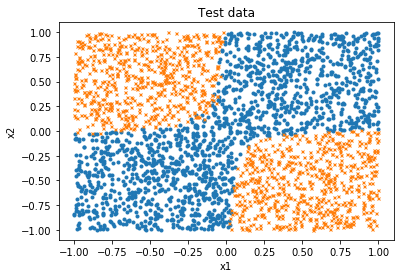

In [4]:
# data

n = 3000

x1 = np.random.random(n)*2-1
x2 = np.random.random(n)*2-1
y = s(x1,x2) + np.random.randn(n)*0.1
cat = np.array(y>0.5,dtype=int)

plt.plot(x1[cat==0],x2[cat==0],'o',ls='',ms=3)
plt.plot(x1[cat==1],x2[cat==1],'x',ls='',ms=3)
plt.ylabel('x2')
plt.xlabel('x1')
plt.title('Test data')
plt.show()

In [5]:
# 80% of data for training
c = int(8*n/10)

x = np.zeros((x1.size,2))
x[:,0] = x1
x[:,1] = x2

# split train and test
training_data = (torch.Tensor(x[:c,:]),torch.Tensor(cat[:c]).long())
test_data = (torch.Tensor(x[c:,:]), torch.Tensor(cat[c:]).long())

### Simple training

In [6]:
def train(model, loss_fn, 
          training_data,
          test_data,
          epochs=1000, learning_rate=1e-1):
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    for i in range(epochs):
        # Forward pass: compute predicted y by passing x to the model.
        y_pred = model(training_data[0])

        # Compute and print loss.
        loss = loss_fn(y_pred, training_data[1])
        if i%100 == 0:
            test_pred = model(test_data[0])
            test_accuracy = 1 - (test_pred[:,1].long()-test_data[1]).abs().sum().item()/test_pred.size(0)
            print(f'[epoch {i}]: loss = {loss.item():.3f}, test accuracy = {test_accuracy:.3f}')

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
def predict(model,test_data):
    return model(test_data[0])

def plot_prediction(model,data):
    pred = np.argmax(predict(model,data).detach().numpy(),axis=1)
    plt.plot(np.array(data[0][np.where(pred==0)[0],0]),
             np.array(data[0][np.where(pred==0)[0],1]),'o',ls='',ms=3)
    plt.plot(np.array(data[0][np.where(pred==1)[0],0]),
             np.array(data[0][np.where(pred==1)[0],1]),'x',ls='',ms=3)
    plt.ylabel('x2')
    plt.xlabel('x1')
    plt.title('Prediction')
    plt.show()

### Model 1

In [7]:
# define a model

model1 = nn.Sequential(
    TaylorNet(2,4),
    nn.Tanh(),
    nn.Linear(4,2),
    nn.Softmax(dim=1),
)
loss_fn = nn.CrossEntropyLoss()

# train
train(model1, loss_fn, training_data, test_data)

[epoch 0]: loss = 0.694, test accuracy = 0.558
[epoch 100]: loss = 0.330, test accuracy = 0.788
[epoch 200]: loss = 0.324, test accuracy = 0.858
[epoch 300]: loss = 0.323, test accuracy = 0.912
[epoch 400]: loss = 0.322, test accuracy = 0.928
[epoch 500]: loss = 0.321, test accuracy = 0.940
[epoch 600]: loss = 0.320, test accuracy = 0.948
[epoch 700]: loss = 0.320, test accuracy = 0.960
[epoch 800]: loss = 0.320, test accuracy = 0.965
[epoch 900]: loss = 0.319, test accuracy = 0.967


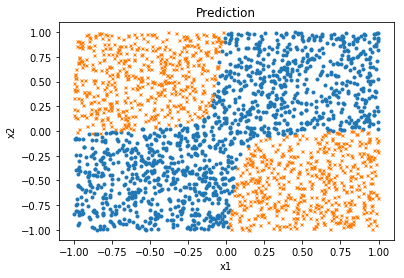

In [8]:
# plot the prediction on the training data

plot_prediction(model1, training_data)

### Model 2

In [11]:
# define a model

model2 = nn.Sequential(
    TaylorNet(2,3),
    TaylorNet(3,2),
    nn.Softmax(dim=1),
)
loss_fn = nn.CrossEntropyLoss()

# train
train(model2, loss_fn, training_data, test_data)

[epoch 0]: loss = 0.668, test accuracy = 0.558
[epoch 100]: loss = 0.328, test accuracy = 0.947
[epoch 200]: loss = 0.327, test accuracy = 0.967
[epoch 300]: loss = 0.323, test accuracy = 0.978
[epoch 400]: loss = 0.323, test accuracy = 0.982
[epoch 500]: loss = 0.327, test accuracy = 0.982
[epoch 600]: loss = 0.328, test accuracy = 0.983
[epoch 700]: loss = 0.327, test accuracy = 0.983
[epoch 800]: loss = 0.325, test accuracy = 0.987
[epoch 900]: loss = 0.324, test accuracy = 0.982


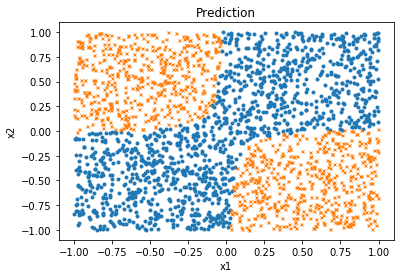

In [12]:
# plot the prediction on the training data

plot_prediction(model2, training_data)